In [1]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm
import torch
import torch.nn as nn



In [2]:
#Multi-Layer Perception

class NN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        act=torch.nn.Tanh,
    ):
        super(NN,self).__init__()

        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth):
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out
    


In [12]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
        
        

        self.model = NN(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth = 4,
            act=torch.nn.Tanh
        ).to(device)

        self.h = 0.1
        self.k = 0.1

        x = torch.arange(-1,1+self.h, self.h)
        t = torch.arange(0,1+self.k, self.k)

        #exact solution
        self.X =torch.stack(torch.meshgrid(x, t)).reshape(2,-1).T

        #training data

        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True

        self.criterion = torch.nn.MSELoss()
        self.iter = 1


        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0, 
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-07,
            tolerance_change=1.0*np.finfo(float).eps,
            line_search_fn="strong_wolfe", #for better numerical stability

        )
       
        self.adam = torch.optim.Adam(self.model.parameters())


    def loss_func(self):
        #this is more like a not so elegant hack to zero grad both optimizers
        self.adam.zero_grad()
        self.optimizer.zero_grad()


        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            inputs=self.X,
            outputs=u,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True,
        )[0]

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]
        du_dxx = torch.autograd.grad(
            inputs=self.X,
            outputs=du_dx,
            grad_outputs=torch.ones_like(du_dx),
            retain_graph=True,
            create_graph=True,
        )[0][:,0]


        loss_pde = self.criterion(du_dt+u.squeeze()*du_dx,0.01/math.pi*du_dxx)
        loss = loss_data + loss_pde
        loss.backward()
        if self.iter % 100 ==0:
            print(self.iter,loss.item())
        self.iter = self.iter + 1
        return loss


    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    
    def eval_(self):
        self.model.eval()
        
        

In [11]:
#device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cuda


Training

In [6]:
net = Net()
net.train()

c:\Users\Nirajan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\Nirajan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ..\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


100 0.1885661482810974
200 0.10425785183906555
300 0.08106683939695358
400 0.064224973320961
500 0.03847046568989754
600 0.02881000190973282
700 0.02101082168519497
800 0.01696411892771721
900 0.022118568420410156
1000 0.016426829621195793
1100 0.008674371987581253
1200 0.005421025212854147
1300 0.0035005821846425533
1400 0.002244343049824238
1500 0.0016154111362993717
1600 0.0021095413248986006
1700 0.0009365954902023077
1800 0.0008011360769160092
1900 0.0007112122257240117
2000 0.0005936420056968927
2100 0.0004319277941249311
2200 0.0003720832464750856
2300 0.00031983290682546794
2400 0.00026205647736787796
2500 0.00020660157315433025
2600 0.00017626343469601125
2700 0.00015397384413518012
2800 0.00014007643039803952
2900 0.00012318183144088835
3000 0.00010788799409056082
3100 9.767746814759448e-05
3200 7.945445395307615e-05
3300 7.166417344706133e-05


Evaluation

In [ ]:
#net.eval_()
net.model.eval()
h = 0.01
k = 0.01
x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

#exact solution

X = torch.stack(torch.meshgrid(x, t)).reshape(2,-1).T
X = X.to(net.X.device)

model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).cpu().numpy()




In [ ]:
sns.set_style("white")

plt.figure(figsize = (5,3),dpi = 3000)


<Figure size 15000x9000 with 0 Axes>

<Figure size 15000x9000 with 0 Axes>

In [ ]:
y_pred

array([[ 0.00068261,  0.00055491,  0.00048887, ...,  0.00025671,
         0.00023591,  0.00021376],
       [ 0.03197994,  0.03095072,  0.03003313, ...,  0.00806292,
         0.00798311,  0.00790291],
       [ 0.06319945,  0.06126916,  0.05950015, ...,  0.01586648,
         0.01572805,  0.01559021],
       ...,
       [-0.09265298, -0.08988587, -0.08734689, ..., -0.02348719,
        -0.02329133, -0.02309481],
       [-0.06230328, -0.06042392, -0.058731  , ..., -0.01556049,
        -0.01541672, -0.01527224],
       [-0.03190822, -0.03092322, -0.0300794 , ..., -0.00760827,
        -0.0075169 , -0.00742362]], dtype=float32)

<Axes: >

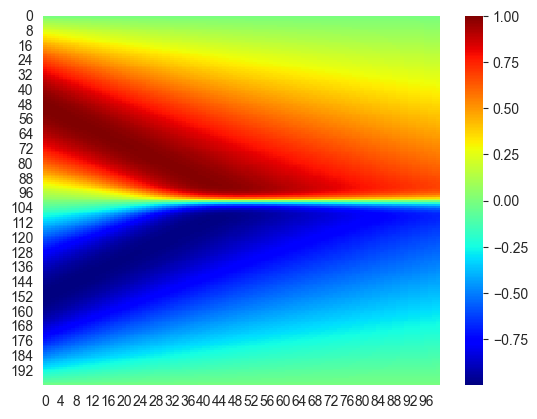

In [ ]:
sns.heatmap(y_pred,cmap='jet')